## Exercício Aula 3 - 26/08/2022

In [94]:
# Carrega as bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.stem.porter import *
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re

In [95]:
# Queremos identificar se a mensagem é um spam (1) ou não (0)
spam = pd.read_csv("dataset/SMSSpamCollection", sep = "\t", names = ["label","message"])
spam.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [96]:
spam.info()
# Sem valores nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [97]:
# Trocando os labels para '0' ('ham') e '1' ('spam')
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
label = le.fit_transform(spam["label"])

In [98]:
label

array([0, 0, 1, ..., 0, 0, 0])

In [99]:
spam["label"] = label
spam.head()

,label,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [100]:
# Baixa as listas de stopwords e as tokenizações
nltk.download('stopwords')
nltk.download('punkt')

# Define as stopwords em inglês
sw_english = set(stopwords.words('english'))

# Instancia o PorterStemmer | trocar por lemmatização
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [101]:
# Função de Stemming
def pre_text(string):
    string = re.sub(r"[^a-zA-Z0-9]+", " ", string)
    string = string.lower()
    words = word_tokenize(string)
    filter_words = [word for word in words if word not in sw_english]
    stem_words = []
    for word in filter_words:
        sw = stemmer.stem(word)
        stem_words.append(sw)
    return stem_words

In [102]:
spam['filtered_words'] = spam["message"].apply(lambda x: pre_text(x))
spam['join_words'] = spam['filtered_words'].apply(lambda x: ' '.join(x))

In [103]:
from sklearn.model_selection import train_test_split


X = spam["join_words"]
y = spam["label"]

X_train, X_test, y_train, y_test = train_test_split(X,y)

### TrucatedSVD

- Tem muitas features e queremos reduzir a quantidade
- Sabemos que temos features não relevants
- Antes de aplicar o PCA devemos escalar as features originais com StandardScaler
- https://analyticsindiamag.com/beginners-guide-to-truncated-svd-for-dimensionality-reduction/
- https://stackoverflow.com/questions/34725726/is-it-possible-apply-pca-on-any-text-classification
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

### LogisticRegression

In [104]:
# Usar SVD ao invés de PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

text_lr = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("sc", StandardScaler(with_mean=False)),
    ("svd", TruncatedSVD(n_components = 4, random_state = 42)),
    ("lr", LogisticRegression())
])

text_lr

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('sc', StandardScaler(with_mean=False)),
                ('svd', TruncatedSVD(n_components=4, random_state=42)),
                ('lr', LogisticRegression())])

In [105]:
text_lr.fit(X_train, y_train)
predictions = text_lr.predict(X_test)

In [106]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score

confusion_matrix(y_test, predictions)
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93      1217
           1       0.43      0.02      0.03       176

    accuracy                           0.87      1393
   macro avg       0.65      0.51      0.48      1393
weighted avg       0.82      0.87      0.82      1393

0.8729361091170137


In [107]:
y_prob_lr = text_lr.predict_proba(X_test)
# Slice do predict proba
y_prob_lr = y_prob_lr[:,1] 

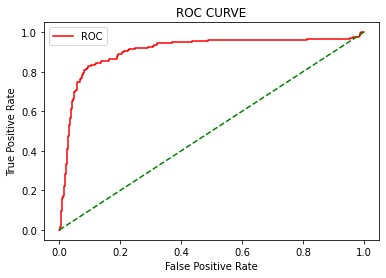

In [108]:
# ROC-AUC 
fp, tp, thresholds = roc_curve(y_test, y_prob_lr)
plt.plot(fp, tp, color = 'red', label = 'ROC')
plt.plot([0,1], [0,1], color='green', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend()
plt.show()

In [109]:
auc = roc_auc_score(y_test, y_prob_lr)
print(auc)

0.9054679913348771


### Random Forest Classifier

In [110]:
# Usar SVD ao invés de PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

text_rf = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("sc", StandardScaler(with_mean=False)),
    ("svd", TruncatedSVD(n_components = 4, random_state = 42)),
    ("rf", RandomForestClassifier())
])

text_rf

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('sc', StandardScaler(with_mean=False)),
                ('svd', TruncatedSVD(n_components=4, random_state=42)),
                ('rf', RandomForestClassifier())])

In [111]:
text_rf.fit(X_train, y_train)
predictions = text_rf.predict(X_test)

In [112]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score

confusion_matrix(y_test, predictions)
print(classification_report(y_test, predictions))
print(accuracy_score(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1217
           1       0.76      0.78      0.77       176

    accuracy                           0.94      1393
   macro avg       0.86      0.87      0.87      1393
weighted avg       0.94      0.94      0.94      1393

0.9404163675520459


In [113]:
y_prob_rf = text_rf.predict_proba(X_test)
y_prob_rf = y_prob_rf[:,1]

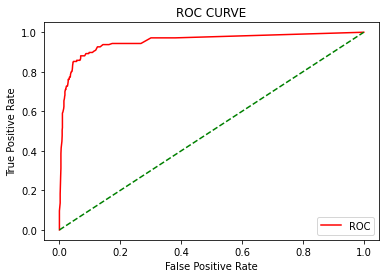

In [114]:
# ROC-AUC 
fp, tp, thresholds = roc_curve(y_test, y_prob_rf)
plt.plot(fp, tp, color = 'red', label = 'ROC')
plt.plot([0,1], [0,1], color='green', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend()
plt.show()

In [115]:
auc = roc_auc_score(y_test, y_prob_rf)
print(auc)

0.9534646485396281
